<a href="https://colab.research.google.com/github/danon6868/BI-ml-2024/blob/main/lecture_8_pytorch/homework/FC_NN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [122]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [176]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [231]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:**

Посмотрим на какую-нибудь картинку:

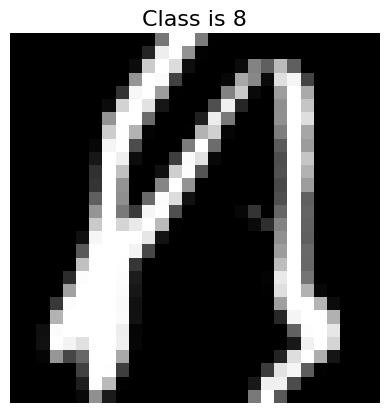

In [232]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





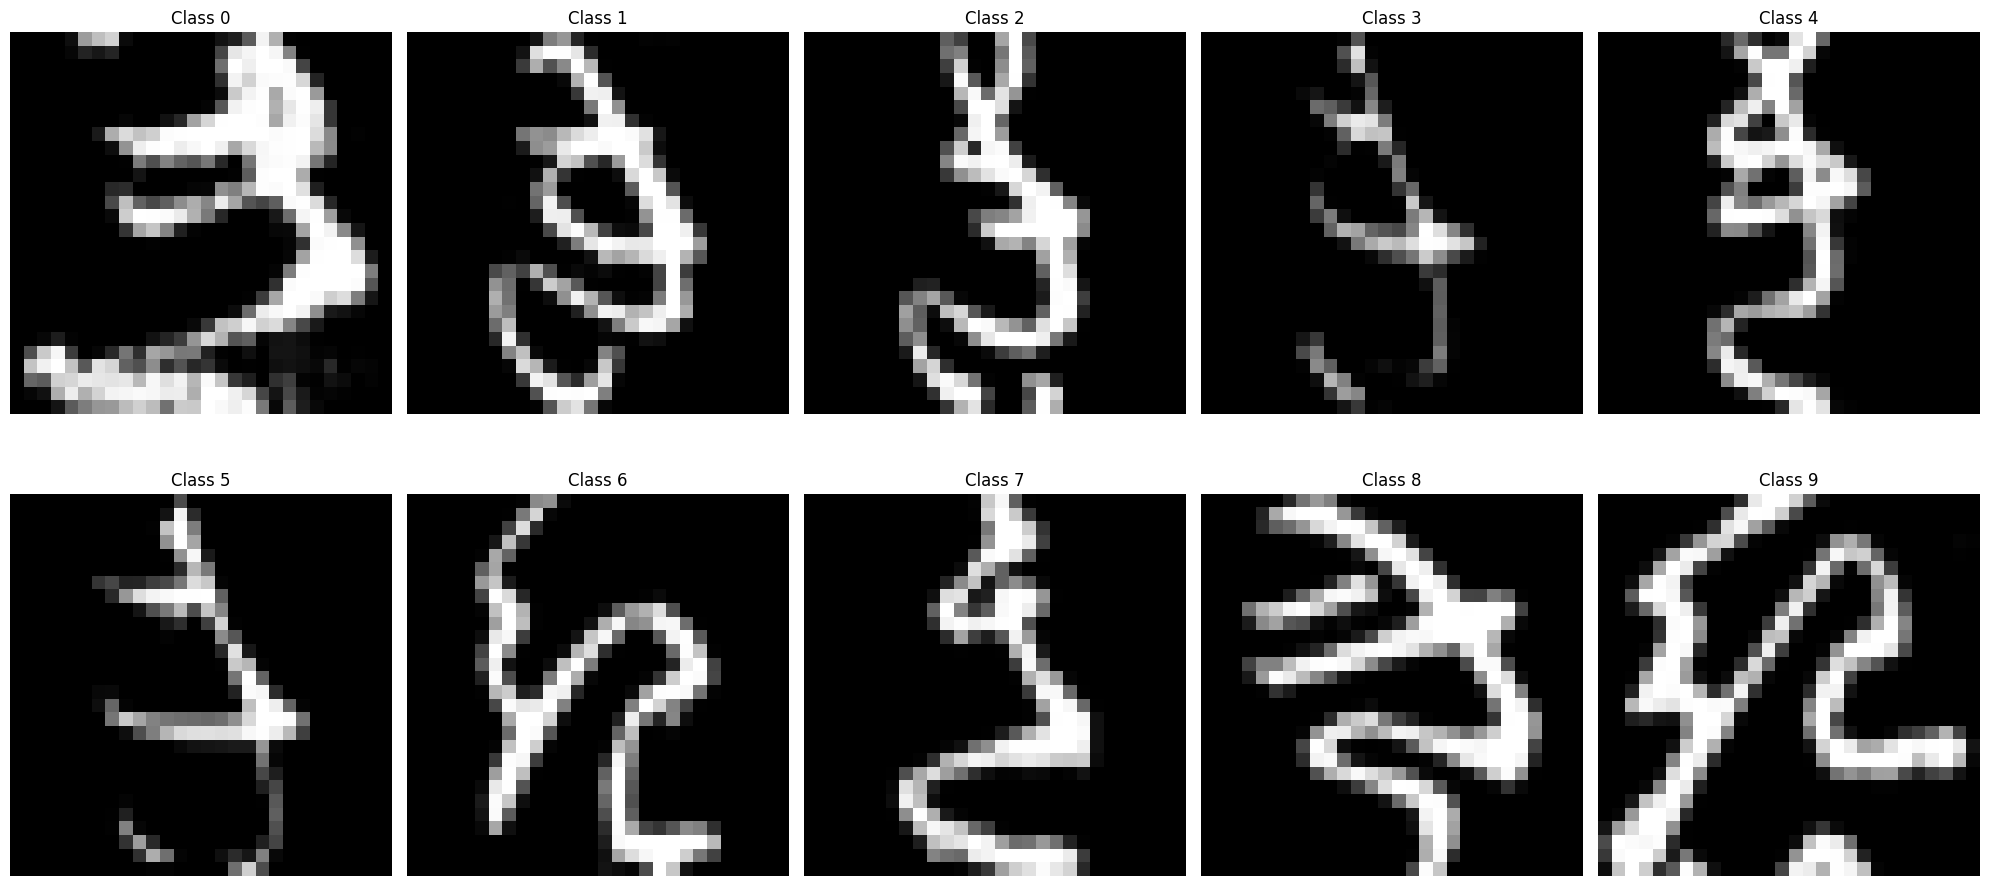

In [233]:
fig = plt.subplots(2, 5, figsize=(20, 10))

for class_label in range(10):
    indices = np.where(trainset.targets == 1)[0]
    random_index = np.random.choice(indices)
    image = trainset.data[random_index].view(28, 28).numpy()
    plt.subplot(2, 5, class_label+1)
    plt.imshow(image,cmap="gray")
    plt.axis("off")
    plt.title(f"Class {class_label}")

plt.tight_layout()
plt.show()

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.

https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [234]:
import torch.nn as nn
import torch.nn.functional as F

class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)


    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        logits = self.fc3(x)
        # на выходе нам нужны логиты, поэтому актвация после последнего слоя, кажется, не требуется

        return logits

Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:**

In [235]:
# Создадим объект модели
fc_net = FCNet()

for param in fc_net.parameters():
    print(param.shape)

torch.Size([256, 784])
torch.Size([256])
torch.Size([128, 256])
torch.Size([128])
torch.Size([10, 128])
torch.Size([10])


In [236]:
w = 784*256 + 256*128 + 128*10
b = 256 + 128 + 10
parameters = w + b
print(f'Number of model parameters: {parameters} ({w} weights and {b} biases)')

Number of model parameters: 235146 (234752 weights and 394 biases)


### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [237]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total

    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [238]:
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [239]:
n_epochs = 10
loss_history = []
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.9173
Epoch=2 loss=0.4421
Epoch=3 loss=0.3457
Epoch=4 loss=0.2891
Epoch=5 loss=0.2477
Epoch=6 loss=0.2145
Epoch=7 loss=0.1861
Epoch=8 loss=0.1642
Epoch=9 loss=0.1443
Epoch=10 loss=0.1267


In [240]:
get_accuracy(fc_net, testloader)

0.8732

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [241]:
mean =  torch.mean((next(iter(trainloader)))[0])
std = torch.std((next(iter(trainloader)))[0])

transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm
testset.transform = transform_with_norm

print(f'Mean {mean:.4f}\n Std {std:.4f}')

Mean 0.1809
 Std 0.3469


In [242]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [243]:
n_epochs = 10
loss_history = []
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.6866
Epoch=2 loss=0.3013
Epoch=3 loss=0.2209
Epoch=4 loss=0.1709
Epoch=5 loss=0.1375
Epoch=6 loss=0.1111
Epoch=7 loss=0.0906
Epoch=8 loss=0.0744
Epoch=9 loss=0.0609
Epoch=10 loss=0.0491


In [244]:
accuracy_relu = get_accuracy(fc_net, testloader)
print(f'Accuracy after normalization: {accuracy_relu}')

Accuracy after normalization: 0.8956


Как изменилась `accuracy` после нормализации?

> После нормализации `accuracy` повысилась: стала **0.8956** (до нормализации было **0.8732**)

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

### Sigmoid

In [245]:
class FCNet_sigmoid(nn.Module):
    def __init__(self):
      super().__init__()
      self.fc1 = nn.Linear(in_features=28*28, out_features=256)
      self.fc2 = nn.Linear(in_features=256, out_features=128)
      self.fc3 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = F.sigmoid(x)  
        x = self.fc2(x)
        x = F.sigmoid(x)
        logits = self.fc3(x)
        return logits

In [246]:
fc_net = FCNet_sigmoid()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [247]:
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = fc_net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=1.5411
Epoch=2 loss=0.7509
Epoch=3 loss=0.5433
Epoch=4 loss=0.4382
Epoch=5 loss=0.3687
Epoch=6 loss=0.3160
Epoch=7 loss=0.2734
Epoch=8 loss=0.2391
Epoch=9 loss=0.2101
Epoch=10 loss=0.1855


In [248]:
accuracy = get_accuracy(fc_net, testloader)
print(f'Accuracy score using sigmoid activation function: {accuracy}')

Accuracy score using sigmoid activation function: 0.8575


#### GELU

In [249]:
class FCNet_gelu(nn.Module):
    def __init__(self):
      super().__init__()
      self.fc1 = nn.Linear(in_features=28*28, out_features=256)
      self.fc2 = nn.Linear(in_features=256, out_features=128)
      self.fc3 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = F.gelu(x)  
        x = self.fc2(x)
        x = F.gelu(x)
        logits = self.fc3(x)
        return logits

In [250]:
fc_net = FCNet_gelu()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [251]:
n_epochs = 10
loss_history = []
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = fc_net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.6560
Epoch=2 loss=0.2781
Epoch=3 loss=0.1991
Epoch=4 loss=0.1513
Epoch=5 loss=0.1202
Epoch=6 loss=0.0947
Epoch=7 loss=0.0755
Epoch=8 loss=0.0610
Epoch=9 loss=0.0480
Epoch=10 loss=0.0376


In [252]:
accuracy = get_accuracy(fc_net, testloader)
print(f'Accuracy score using GELU activation function: {accuracy}')

Accuracy score using GELU activation function: 0.904


### Tanh

In [253]:
class FCNet_tanh(nn.Module):
    def __init__(self):
      super().__init__()
      self.fc1 = nn.Linear(in_features=28*28, out_features=256)
      self.fc2 = nn.Linear(in_features=256, out_features=128)
      self.fc3 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = F.tanh(x)  
        x = self.fc2(x)
        x = F.tanh(x)
        logits = self.fc3(x)
        return logits

In [254]:
fc_net = FCNet_tanh()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [255]:
n_epochs = 10
loss_history = []
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = fc_net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.7796
Epoch=2 loss=0.3894
Epoch=3 loss=0.2615
Epoch=4 loss=0.1869
Epoch=5 loss=0.1385
Epoch=6 loss=0.1019
Epoch=7 loss=0.0771
Epoch=8 loss=0.0578
Epoch=9 loss=0.0422
Epoch=10 loss=0.0313


In [256]:
accuracy = get_accuracy(fc_net, testloader)
print(f'Accuracy score using Tanh activation function: {accuracy}')

Accuracy score using Tanh activation function: 0.8972


С использованием какой функции активации удалось достичь наибольшей `accuracy`?

> Наибольшей accuracy удалось достичь с использованием функции активации **GELU**.

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

#### RMSprop

In [257]:
fc_net = FCNet_gelu()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(fc_net.parameters(), lr=3e-4)

In [258]:
n_epochs = 10
loss_history = []
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = fc_net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.4354
Epoch=2 loss=0.2380
Epoch=3 loss=0.1763
Epoch=4 loss=0.1352
Epoch=5 loss=0.1062
Epoch=6 loss=0.0835
Epoch=7 loss=0.0660
Epoch=8 loss=0.0521
Epoch=9 loss=0.0399
Epoch=10 loss=0.0305


In [259]:
accuracy = get_accuracy(fc_net, testloader)
print(f'Accuracy score using RMSprop optimizer: {accuracy}')

Accuracy score using RMSprop optimizer: 0.901


#### Adagrad

In [260]:
fc_net = FCNet_gelu()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(fc_net.parameters(), lr=3e-4)

In [261]:
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = fc_net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=1.3437
Epoch=2 loss=0.8165
Epoch=3 loss=0.6932
Epoch=4 loss=0.6304
Epoch=5 loss=0.5913
Epoch=6 loss=0.5630
Epoch=7 loss=0.5411
Epoch=8 loss=0.5233
Epoch=9 loss=0.5082
Epoch=10 loss=0.4957


In [262]:
accuracy = get_accuracy(fc_net, testloader)
print(f'Accuracy score  using Adagrad optimizer: {accuracy}')

Accuracy score  using Adagrad optimizer: 0.7202


**Итого:**
- Adam optimizer: 0.904
- MSprop optimizer: 0.901
- Adagrad optimizer: 0.7202

Adam и MSprop показывают близкие друг к другу, одинаково высокие значения accuracy, Adagrad тем временем сильно от них отстает.

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [265]:
class CustomReLU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # YOUR CODE HERE
        # если элемент x < 0, то 0, если >= 0, то x
        x = torch.where(x < 0, 0, x)
        return x

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [266]:
class FCNet_cust_relu(nn.Module):
    def __init__(self):
      super().__init__()
      self.fc1 = nn.Linear(in_features=28*28, out_features=256)
      self.fc2 = nn.Linear(in_features=256, out_features=128)
      self.fc3 = nn.Linear(in_features=128, out_features=10)
      self.activation = CustomReLU()

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.activation(x)  
        x = self.fc2(x)
        x = self.activation(x)
        logits = self.fc3(x)
        return logits

In [267]:
fc_net = FCNet_cust_relu()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [268]:
n_epochs = 10
loss_history = []
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = fc_net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.6858
Epoch=2 loss=0.2996
Epoch=3 loss=0.2206
Epoch=4 loss=0.1711
Epoch=5 loss=0.1357
Epoch=6 loss=0.1099
Epoch=7 loss=0.0896
Epoch=8 loss=0.0735
Epoch=9 loss=0.0598
Epoch=10 loss=0.0483


In [269]:
accuracy_cust_relu = get_accuracy(fc_net, testloader)
print(f'Accuracy score using Custom_ReLU: {accuracy_cust_relu}')
print(f'Accuracy score for standard ReLU: {accuracy_relu}')

Accuracy score using Custom_ReLU: 0.9018
Accuracy score for standard ReLU: 0.8956


С помощью кастомной ReLu получили accuracy немного повыше.

### Задание 8. Генерация картинок

**3** балла

Придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.

#### **PlaygroundAI**-generated images

Prompt: The artificial intelligence machine created to predict Dota matches results


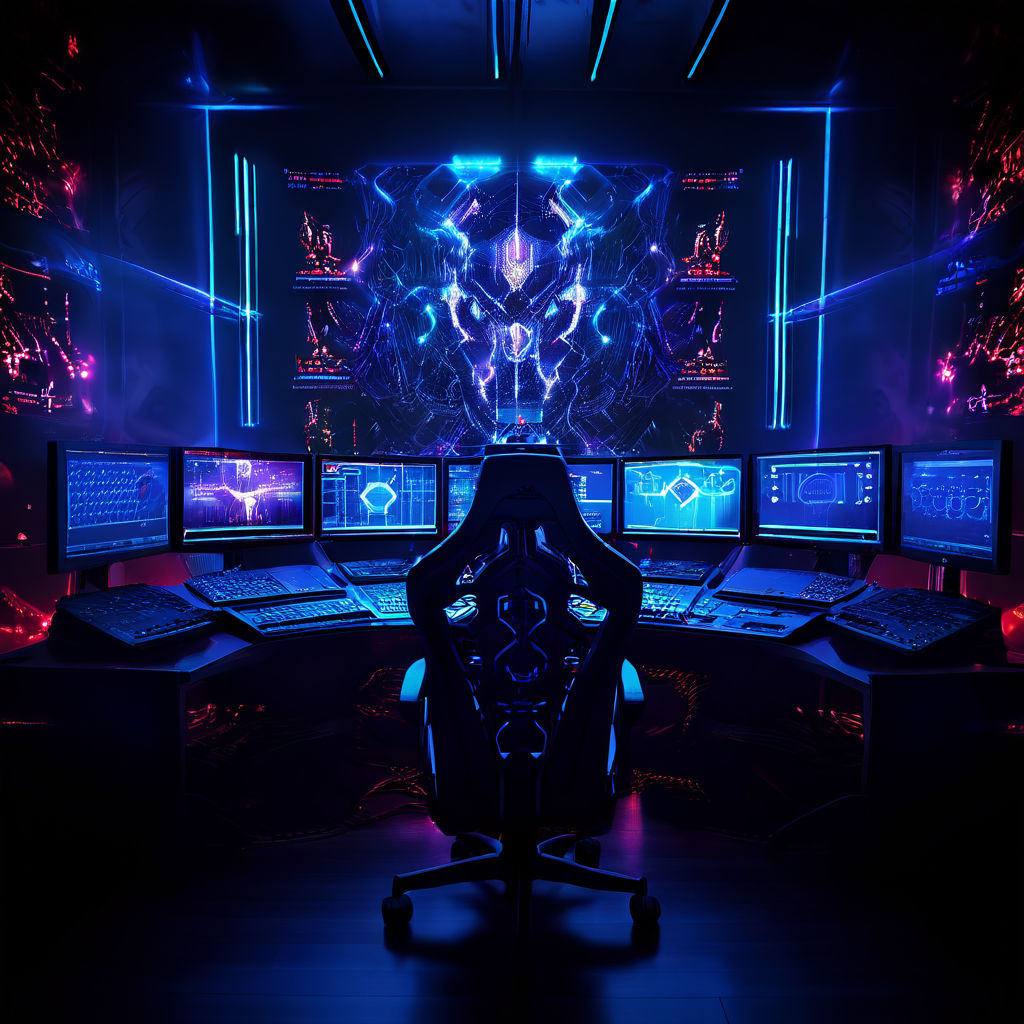

In [277]:
from IPython.display import Image

print("Prompt: The artificial intelligence machine created to predict Dota matches results")
Image(filename='../AI_images/dota_prediction_machine.jpeg') 

Prompt: Biologists discovering a plant with one million chromosomes


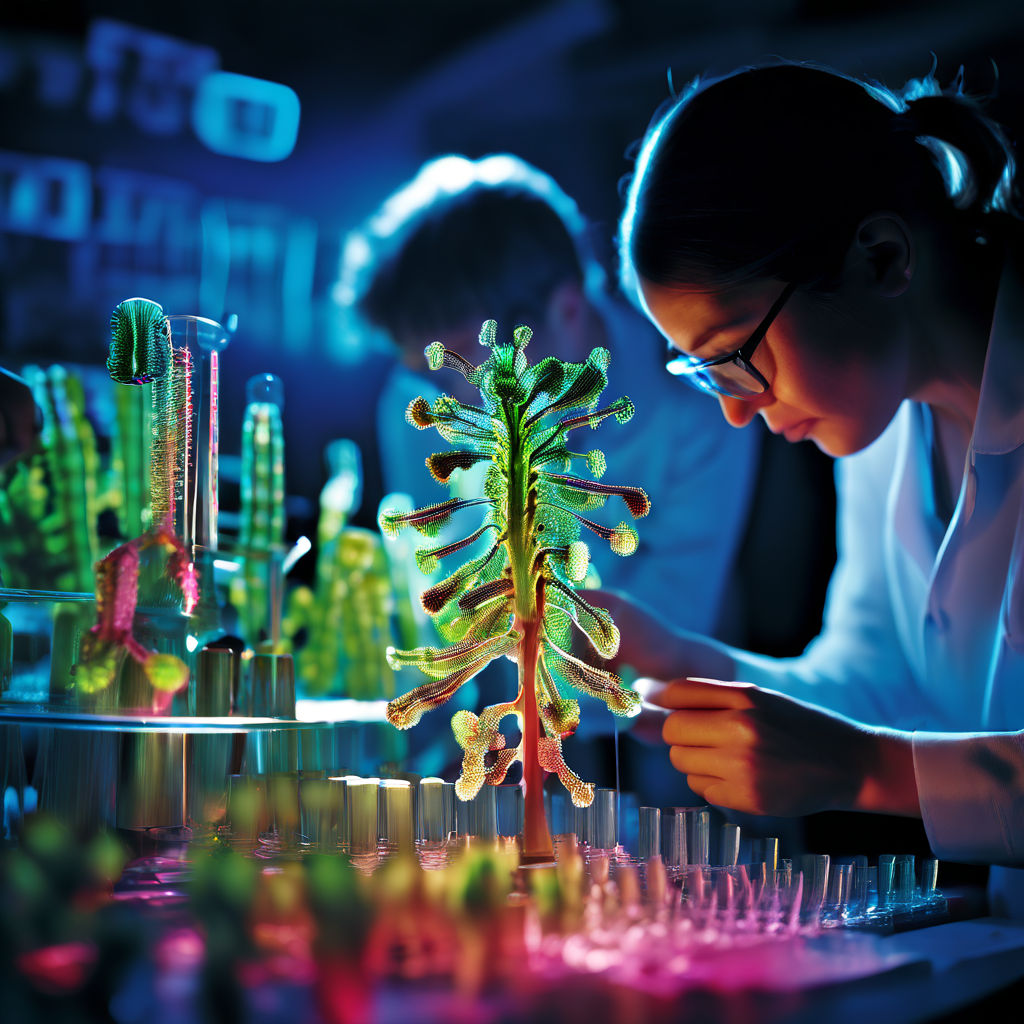

In [278]:
print("Prompt: Biologists discovering a plant with one million chromosomes")
Image(filename='../AI_images/one_million_chromosomes_plant.jpeg') 

Prompt: The conference for the most disorganized and introverted bioinformaticians


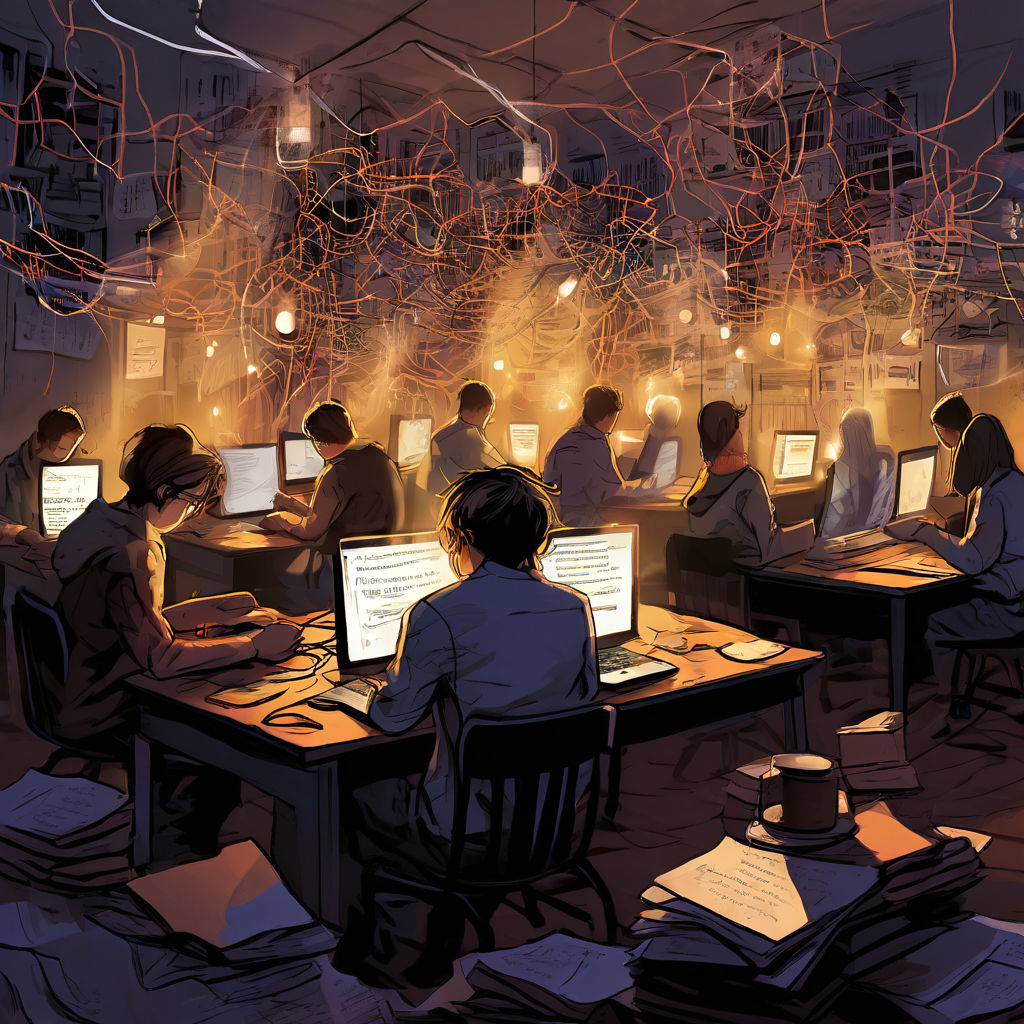

In [280]:
print("Prompt: The conference for the most disorganized and introverted bioinformaticians")
Image(filename='../AI_images/the_most_chaotic_conference.jpeg') 